In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import torch.nn.functional as F
from denoising_diffusion_pytorch import Unet
#from diffusers import DDIMScheduler,DDPMScheduler
import os

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS
else:
    device = torch.device("cpu")  # Fallback to CPU

In [17]:
class catDataset(Dataset):
    def __init__(self, img_dir, second_img_dir):
        self.img_dir = img_dir
        self.img_names = []

        for filename in os.listdir(img_dir):
            file_path = os.path.join(img_dir, filename)
            if os.path.isfile(file_path):
                self.img_names.append(file_path)
        
        for filename in os.listdir(second_img_dir):
            file_path = os.path.join(second_img_dir, filename)
            if os.path.isfile(file_path):
                self.img_names.append(file_path)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        image = read_image(self.img_names[idx])
        image = image.to(torch.float32)/255.0
        return image

In [13]:
def get_model_size(model):
    return sum(p.numel() for p in model.parameters())


In [18]:
ds=catDataset("./cats","./mycat_64x64")
batch_size = 64
train_dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [36]:
total_timesteps = 7
grid_size = [1,2,4,8,16,32,64]

In [44]:
def pixelate_same_size(image: torch.Tensor, grid_size: int) -> torch.Tensor:
    if len(image.shape) == 3:  # If single image, add batch dimension
        image = image.unsqueeze(0)

    B, C, H, W = image.shape

    assert H % grid_size == 0 and W % grid_size == 0, "H and W must be divisible by grid_size"

    # Reshape into grid cells
    image = image.view(B, C, H // grid_size, grid_size, W // grid_size, grid_size)
    
    # Average over each grid cell
    image = image.mean(dim=(3, 5))
    
    # Upscale back to original size
    pixelated = image.repeat_interleave(grid_size, dim=2).repeat_interleave(grid_size, dim=3)

    if len(image.shape) == 3:  # If single image, remove batch dimension
        pixelated = pixelated.squeeze(0)
    
    return pixelated

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, ema):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X) in enumerate(dataloader):
        x_0 = X.to(device)
        curr_bs = X.shape[0]
        t = torch.randint(0,total_timesteps,(curr_bs,))
        pixed = pixelate_same_size(x_0,grid_size[t])
        noise = x_0 - pixelate_same_size()

        t=t.to(device)

        pred = model(pixed,t) # Predict noise at t
        loss = loss_fn(noise,pred) # Difference between predicted noise and true

        # Backpropagation
        loss.backward()
        optimizer.step()
        ema.update()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
training = True
if(training):
    model = Unet(
        dim=64,
        channels=3,
        dim_mults=[1,2,4,8],
        flash_attn=True,
    ).to(device)
    losf = nn.MSELoss()
    print(f"Model has {get_model_size(model)} parameters")
    epochs = 10
    opt = torch.optim.AdamW(model.parameters(),2e-5)
    for i in range(epochs):
        print(f"Epoch {i}")
        train_loop(train_dataloader,model,losf,opt,ema)
else:
    model = torch.load("./1epc.pth",map_location=torch.device(device))

/var/folders/6l/13w1_dn91fxf5c7gjbwgk1q40000gn/T/ipykernel_5248/820304991.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./1epc.pth",map_location=t

In [108]:
#ema.apply()
torch.save(model,"1epc.pth")

tensor([[[[0.8189, 0.8189, 0.8189,  ..., 0.2224, 0.2224, 0.2224],
          [0.8189, 0.8189, 0.8189,  ..., 0.2224, 0.2224, 0.2224],
          [0.8189, 0.8189, 0.8189,  ..., 0.2224, 0.2224, 0.2224],
          ...,
          [0.4896, 0.4896, 0.4896,  ..., 0.1042, 0.1042, 0.1042],
          [0.4896, 0.4896, 0.4896,  ..., 0.1042, 0.1042, 0.1042],
          [0.4896, 0.4896, 0.4896,  ..., 0.1042, 0.1042, 0.1042]],

         [[0.6819, 0.6819, 0.6819,  ..., 0.1622, 0.1622, 0.1622],
          [0.6819, 0.6819, 0.6819,  ..., 0.1622, 0.1622, 0.1622],
          [0.6819, 0.6819, 0.6819,  ..., 0.1622, 0.1622, 0.1622],
          ...,
          [0.3640, 0.3640, 0.3640,  ..., 0.0855, 0.0855, 0.0855],
          [0.3640, 0.3640, 0.3640,  ..., 0.0855, 0.0855, 0.0855],
          [0.3640, 0.3640, 0.3640,  ..., 0.0855, 0.0855, 0.0855]],

         [[0.3776, 0.3776, 0.3776,  ..., 0.1113, 0.1113, 0.1113],
          [0.3776, 0.3776, 0.3776,  ..., 0.1113, 0.1113, 0.1113],
          [0.3776, 0.3776, 0.3776,  ..., 0

In [ ]:
images = []
with torch.no_grad():
    #ema.apply()  # Apply EMA parameters to the model if applicable
    x_t = torch.randn_like(ds[0]).unsqueeze(0).to(device)  # Initialize z on the correct device
    
    # Loop through timesteps in reverse order
    for t in reversed(range(0, total_timesteps)):
        t_tensor = torch.tensor([t], device=device)  # Ensure timestep is a tensor on the correct device
        if t>1:
            z = torch.randn_like(x_t)
        else:
            z = torch.zeros_like(x_t)
    
        front = 1/torch.sqrt(sch.alpha[t])
        that = (1-sch.alpha[t])/(torch.sqrt(1-sch.alpha[t]))
        print(np.sqrt(sch.beta[t]))
        x_t = (front * ((x_t) - (that * model(x_t,t_tensor)))) + (np.sqrt(sch.beta[t]) * z)

        if(t%100 == 0):
            images.append(z)

tensor(0.1414)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


tensor(0.1414)
tensor(0.1413)
tensor(0.1412)
tensor(0.1411)
tensor(0.1411)
tensor(0.1410)
tensor(0.1409)
tensor(0.1409)
tensor(0.1408)
tensor(0.1407)
tensor(0.1406)
tensor(0.1406)
tensor(0.1405)
tensor(0.1404)
tensor(0.1404)
tensor(0.1403)
tensor(0.1402)
tensor(0.1401)
tensor(0.1401)
tensor(0.1400)
tensor(0.1399)
tensor(0.1399)
tensor(0.1398)
tensor(0.1397)
tensor(0.1396)
tensor(0.1396)
tensor(0.1395)
tensor(0.1394)
tensor(0.1394)
tensor(0.1393)
tensor(0.1392)
tensor(0.1391)
tensor(0.1391)
tensor(0.1390)
tensor(0.1389)
tensor(0.1389)
tensor(0.1388)
tensor(0.1387)
tensor(0.1386)
tensor(0.1386)
tensor(0.1385)
tensor(0.1384)
tensor(0.1384)
tensor(0.1383)
tensor(0.1382)
tensor(0.1381)
tensor(0.1381)
tensor(0.1380)
tensor(0.1379)
tensor(0.1379)
tensor(0.1378)
tensor(0.1377)
tensor(0.1376)
tensor(0.1376)
tensor(0.1375)
tensor(0.1374)
tensor(0.1373)
tensor(0.1373)
tensor(0.1372)
tensor(0.1371)
tensor(0.1371)
tensor(0.1370)
tensor(0.1369)
tensor(0.1368)
tensor(0.1368)
tensor(0.1367)
tensor(0.1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7695525..4.5896983].


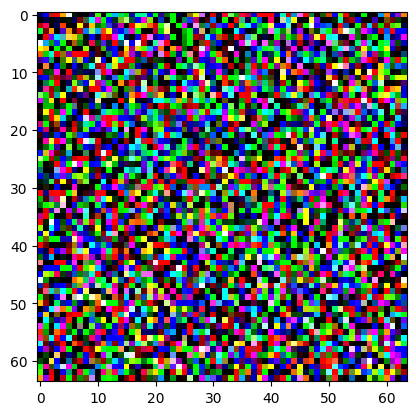

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7695525..4.5896983].


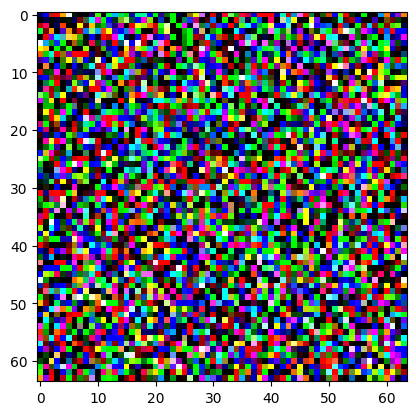

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7695525..4.5896983].


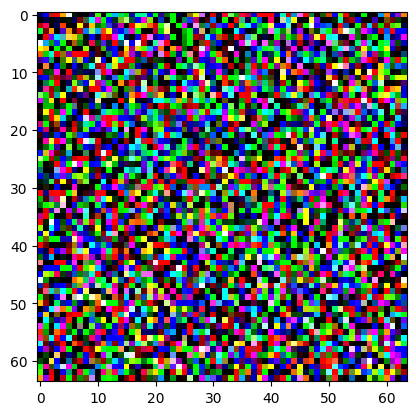

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7695525..4.5896983].


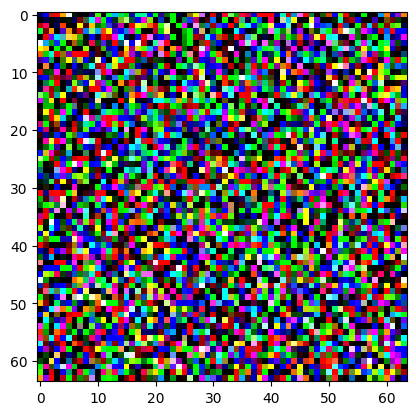

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.118685775..24.921995].


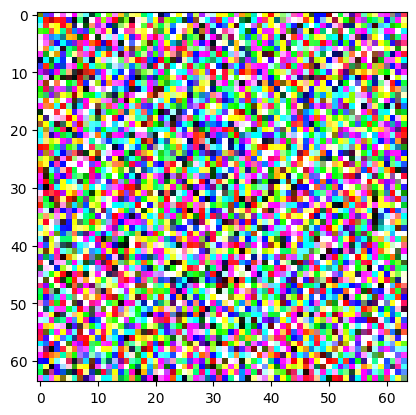

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.118685775..24.921995].


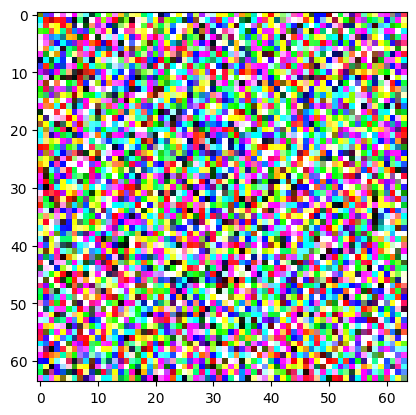

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.118685775..24.921995].


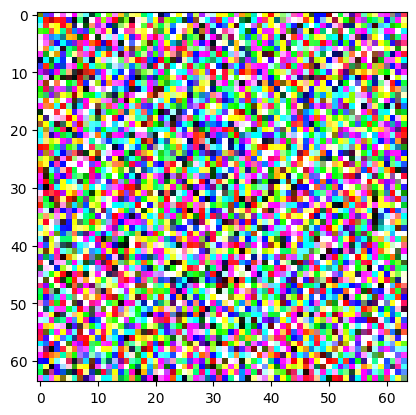

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.118685775..24.921995].


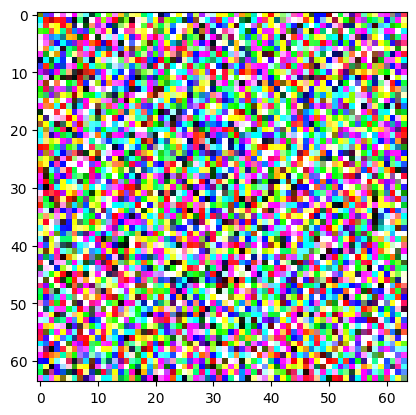

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.118685775..24.921995].


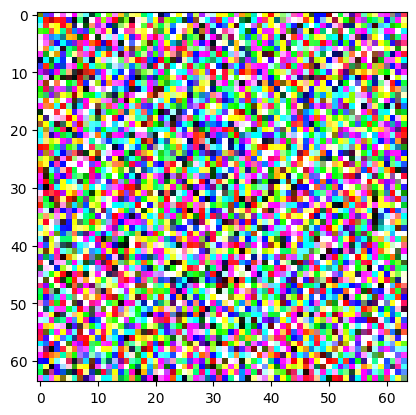

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.118685775..24.921995].


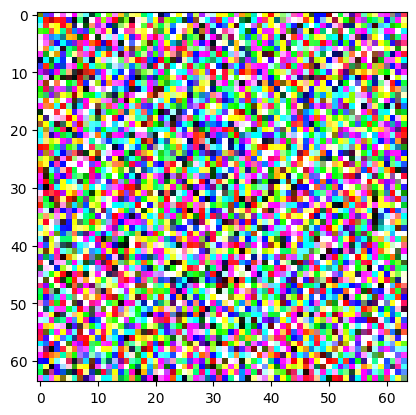

<Figure size 640x480 with 0 Axes>

In [128]:
for i,image in enumerate(images):
    plt.imshow(image.squeeze(0).permute(1,2,0).cpu().detach().numpy())
    plt.show()
    plt.savefig(f"./img_at_step_{i*100}")